In [1]:
%pylab inline
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
#
# Cleveland and McGill: Graphical Perception, 1984
# Figure 12
#
# Weber's Law: differences in encoded numerical quantities
#

In [3]:
def create_rectangles(framed=False, size=(100,100)):
    '''
    '''
    image, A_y, B_y, A_height, B_height = draw_rectangles(framed, size)

    while (np.abs(A_y - B_y) < 10) or (np.abs(A_height - B_height) < 1):
        image, A_y, B_y, A_height, B_height = draw_rectangles(framed, size)        
    
    if A_height > B_height:
        label = 0
    elif A_height < B_height:
        label = 1
    
    return image, label
    

def draw_rectangles(framed, size):
    '''
    '''
    image = np.zeros(size, dtype=np.int8)
    
    max_height = 65
    delta = 5
    width = 20
    
    A_x = 20
    A_y = np.random.randint(size[0] - max_height)
    A_height = np.random.randint(max_height-delta, max_height)
    image[A_y:A_y+max_height,A_x:A_x+1] = 2
    image[A_y:A_y+max_height,A_x+width:A_x+width+1] = 2
    image[A_y:A_y+1,A_x:A_x+width] = 2
    image[A_y+max_height:A_y+max_height+1,A_x:A_x+width+1] = 2
    image[A_y+max_height-A_height:A_y+max_height+1,A_x:A_x+width+1] = 1
    
    B_x = 60
    B_y = np.random.randint(size[0] - max_height)
    B_height = np.random.randint(max_height-delta, max_height)
    image[B_y:B_y+max_height,B_x:B_x+1] = 2
    image[B_y:B_y+max_height,B_x+width:B_x+width+1] = 2
    image[B_y:B_y+1,B_x:B_x+width] = 2
    image[B_y+max_height:B_y+max_height+1,B_x:B_x+width+1] = 2    
    image[B_y+max_height-B_height:B_y+max_height+1,B_x:B_x+width+1] = 1    
    
    if not framed:
        image[image == 2] = 0
    
    return image, A_y, B_y, A_height, B_height


In [4]:
#
# let's create a bunch of samples
#
N = 100000

t0 = time.time()

images = np.zeros((N, 100, 100), dtype=np.bool)
framed_images = np.zeros((N, 100, 100), dtype=np.bool)
labels = np.zeros((N), dtype=np.bool)

for n in range(N):
    
    framed_image, label = create_rectangles(True) # create framed image
    # remove frame
    image = framed_image.copy()
    image[image == 2] = 0
    images[n] = image.astype(np.bool)
    
    # harden frame
    framed_image[framed_image == 2] = 1
    framed_images[n] = framed_image.astype(np.bool)
    
    labels[n] = label
    
print 'Done after', time.time()-t0, 'seconds'
print 'Label 0', len(np.where(labels == 0)[0])
print 'Label 1', len(np.where(labels == 1)[0])

Done after 10.640818119 seconds
Label 0 50212
Label 1 49788


LABEL 0


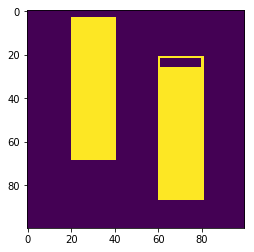

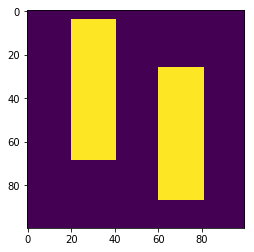

In [5]:
INDEX = 2
imshow(framed_images[INDEX])
plt.figure()
imshow(images[INDEX])
print 'LABEL', int(labels[INDEX])

In [6]:
#
# BULK EXPERIMENT
#
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense


def run_bulk(data, labels, epochs=10, repeats=10):

    repeat_history = []
    for r in range(repeats):

        # shuffle the data
        indices = numpy.random.permutation(len(labels))
        shuffled_data = data[indices]
        shuffled_labels = labels[indices]
        
        model = Sequential()
        model.add(Dense(12, input_dim=100*100, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

        history = model.fit(shuffled_data[0:80000].reshape(80000,100*100), shuffled_labels[0:80000], \
                            epochs=epochs, validation_split=0.25, verbose=False)
        test_results = model.evaluate(shuffled_data[80000:].reshape(20000,100*100), shuffled_labels[80000:])

        repeat_history.append((history, test_results))

    repeat_test_loss = [k[1][0] for k in repeat_history]
    repeat_test_acc = [k[1][1] for k in repeat_history]
    repeat_val_loss = [k[0].history['loss'] for k in repeat_history]
    repeat_val_acc = [k[0].history['acc'] for k in repeat_history]
    
    return repeat_val_loss, repeat_val_acc, repeat_test_loss, repeat_test_acc

Using TensorFlow backend.


In [7]:
#
# NN without frames
#
val_loss, val_acc, test_loss, test_acc = run_bulk(images, labels, epochs=10, repeats=10)

20000/20000 [==============================] - 1s 61us/step


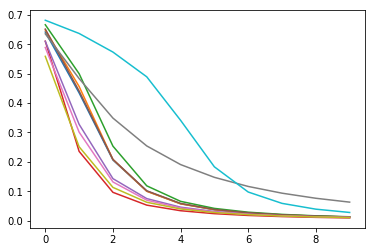

In [8]:
for l in val_loss:
    plot(l)

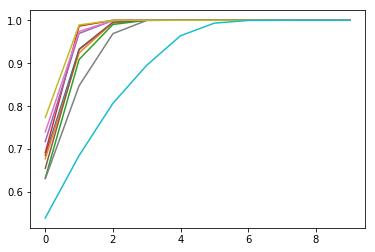

In [9]:
for l in val_acc:
    plot(l)

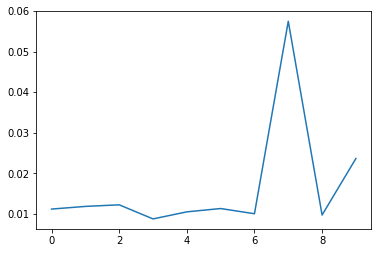

In [10]:
plot(test_loss)

In [11]:
#
# NN with frames
#
framed_val_loss, framed_val_acc, framed_test_loss, framed_test_acc = run_bulk(framed_images, labels, epochs=10, repeats=10)

20000/20000 [==============================] - 1s 61us/step


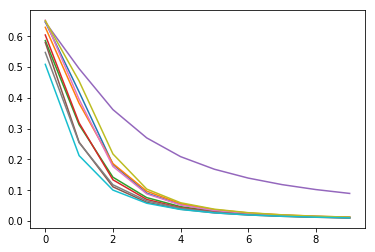

In [12]:
for l in framed_val_loss:
    plot(l)

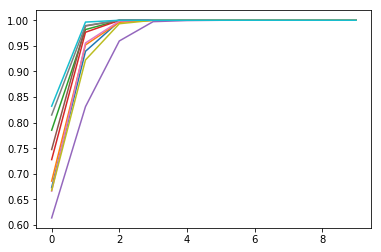

In [13]:
for l in framed_val_acc:
    plot(l)

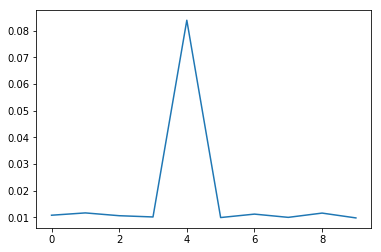

In [14]:
plot(framed_test_loss)

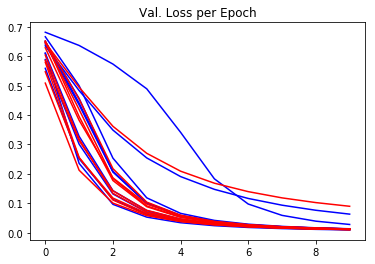

In [45]:
#
# COMPARE
#
for l in val_loss:
    plot(l, color='blue', label='No frames')
for l in framed_val_loss:
    plot(l, color='red', label='Frames')
t = plt.title('Val. Loss per Epoch')


In [36]:
mean_val_loss_per_epoch = []

for e in range(len(val_loss[0])):
    current_loss = 0
    for i,l in enumerate(val_loss):
        current_loss += l[e]
    current_loss /= float(len(val_loss[0]))
    mean_val_loss_per_epoch.append(current_loss)
    
framed_mean_val_loss_per_epoch = []

for e in range(len(framed_val_loss[0])):
    framed_current_loss = 0
    for i,l in enumerate(framed_val_loss):
        framed_current_loss += l[e]
    framed_current_loss /= float(len(framed_val_loss[0]))
    framed_mean_val_loss_per_epoch.append(framed_current_loss)

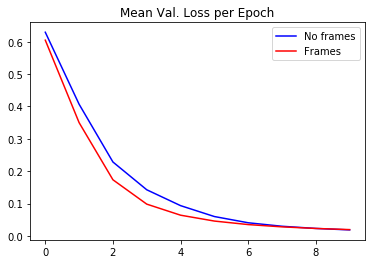

In [47]:
plt.title('Mean Val. Loss per Epoch')
plot(mean_val_loss_per_epoch, color='blue', label='No frames')
plot(framed_mean_val_loss_per_epoch, color='red', label='Frames')
l = plt.legend()

In [48]:
mean_val_acc_per_epoch = []

for e in range(len(val_acc[0])):
    current_acc = 0
    for i,l in enumerate(val_acc):
        current_acc += l[e]
    current_acc /= float(len(val_acc[0]))
    mean_val_acc_per_epoch.append(current_acc)
    
framed_mean_val_acc_per_epoch = []

for e in range(len(framed_val_acc[0])):
    framed_current_acc = 0
    for i,l in enumerate(framed_val_acc):
        framed_current_acc += l[e]
    framed_current_acc /= float(len(framed_val_acc[0]))
    framed_mean_val_acc_per_epoch.append(framed_current_acc)

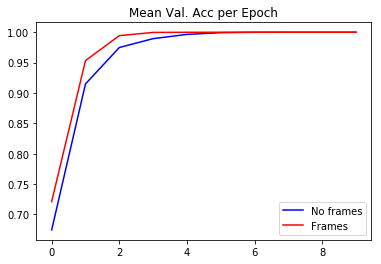

In [49]:
plt.title('Mean Val. Acc per Epoch')
plot(mean_val_acc_per_epoch, color='blue', label='No frames')
plot(framed_mean_val_acc_per_epoch, color='red', label='Frames')
l = plt.legend()

In [28]:
np.mean(val_loss), np.median(val_loss)

(0.16719587586868062, 0.058798541222016013)

In [29]:
np.mean(framed_val_loss), np.median(framed_val_loss)

(0.1441240176310738, 0.049606157601873077)

In [24]:
np.mean(test_loss), np.median(test_loss)

(0.016714028893932701, 0.011295659536123276)

In [23]:
np.mean(framed_test_loss), np.median(framed_test_loss)

(0.017974543155469001, 0.010712869555689394)

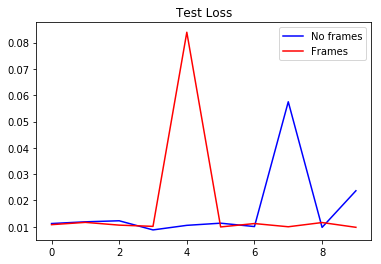

In [51]:
plt.title('Test Loss')
plot(test_loss, color='blue', label='No frames')
plot(framed_test_loss, color='red', label='Frames')
l = plt.legend()